<a href="https://colab.research.google.com/github/zhpinkman/fake-news-detection/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import the required libraries

In [1]:
!pip install transformers

In [2]:
cp kaggle.json /root/.kaggle/

In [3]:
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle kernels output mastmustu/97-fake-news-detection-using-bert-pytorch -p .

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/kaggle/cli.py", line 51, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 2069, in kernels_output_cli
    self.kernels_output(kernel, path, force, quiet)
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 2039, in kernels_output
    os.makedirs(os.path.split(outfile)[0], exist_ok=True)
TypeError: makedirs() got an unexpected keyword argument 'exist_ok'


In [5]:
import numpy as np
import pandas as pd

import torch
import torch as th
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as f

import seaborn as sns
import matplotlib.pyplot as plt

from torch import optim
from wordcloud import WordCloud

import torch.nn as nn

import re
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from transformers import BertForSequenceClassification, BertTokenizer, AutoModelForSequenceClassification, AutoTokenizer, BertModel

### Get the data and remove the duplicates and NaNs

In [6]:
ls | grep csv

train.csv


In [7]:
train_df = pd.read_csv('train.csv')
# test_df = pd.read_csv('test.csv')

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [9]:
def combine_columns(row): 
    return str(row['text']) + ' ' + str(row['title'])

In [10]:
train_df['text_title'] = train_df.apply(combine_columns, axis=1)

In [11]:
train_df.dropna(subset=['text_title'], inplace=True)
train_df.drop_duplicates(subset='text_title', inplace=True)

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20690 entries, 0 to 20799
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          20690 non-null  int64 
 1   title       20172 non-null  object
 2   author      18758 non-null  object
 3   text        20651 non-null  object
 4   label       20690 non-null  int64 
 5   text_title  20690 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.1+ MB


In [13]:
train_df.drop(columns=['title', 'author', 'text'], inplace=True)

In [14]:
train_df.head(3)

,id,label,text_title
0,0,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,0,Ever get the feeling your life circles the rou...
2,2,1,"Why the Truth Might Get You Fired October 29, ..."


In [15]:
id2label = {
    0: 'real', 
    1: 'fake'
}
label2id = {val: key for key, val in id2label.items()}

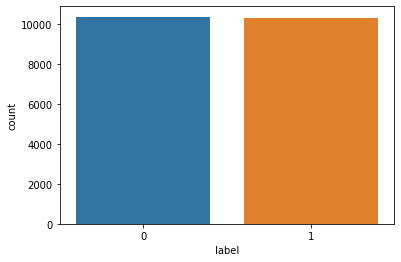

In [16]:
sns.countplot(data=train_df, x='label')

### Number of Characters in the Text

Text(0.5, 1.0, 'Number of characters in the news that are labeled as real')

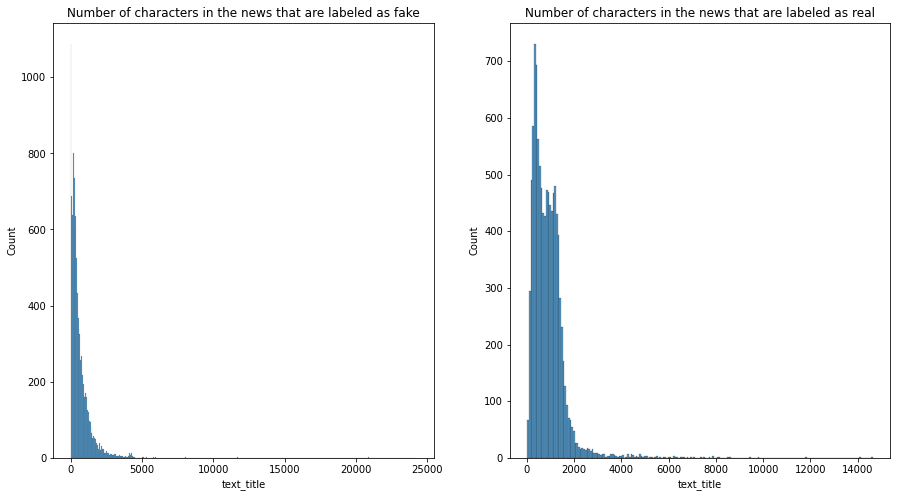

In [17]:
fig, axs = plt.subplots(figsize=(15, 8), ncols=2)
text_lens = train_df[train_df['label'] == 1]['text_title'].apply(lambda x: len(x.split()))
sns.histplot(text_lens, ax=axs[0])
axs[0].set_title('Number of characters in the news that are labeled as fake')
text_lens = train_df[train_df['label'] == 0]['text_title'].apply(lambda x: len(x.split()))
sns.histplot(text_lens, ax=axs[1])
axs[1].set_title('Number of characters in the news that are labeled as real')

### Word Cloud

In [18]:
# fake_text = ' '.join(train_df[train_df['label'] == 1]['text_title'].tolist())
# wc = WordCloud()
# wc_obj = wc.generate(fake_text)
# plt.figure(figsize=(10, 8))
# plt.imshow(wc_obj)
# plt.axis('off')
# plt.show()

In [19]:
# real_text = ' '.join(train_df[train_df['label'] == 0]['text_title'].tolist())
# wc = WordCloud()
# wc_obj = wc.generate(real_text)
# plt.figure(figsize=(10, 8))
# plt.imshow(wc_obj)
# plt.axis('off')
# plt.show()

### Loading the dataset

In [20]:
def text_cleaning(text: str) -> str:
    text = re.sub("[^a-zA-Z]", " ", text) # removing punctuation
    return text

In [21]:
train_df['text'] = train_df['text_title'].apply(text_cleaning)

In [22]:
train_split, val_split = train_test_split(train_df, stratify=train_df['label'], test_size=.2)

In [23]:
class NewsDataset(Dataset):
    def __init__(self, tokenizer: BertTokenizer, split):
        self.texts = split['text_title'].tolist()
        self.labels = split['label'].tolist()
        self.tokenizer = tokenizer
        
    def __getitem__(self, index):
        text = self.texts[index]
        encoded_text = tokenizer(
            text = text, 
            padding='max_length',
            truncation=True,
            return_tensors='pt',
            return_attention_mask=True
        )
        return encoded_text['input_ids'], encoded_text['attention_mask'], self.labels[index]
    def __len__(self):
        return len(self.texts)

In [24]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
train_ds = NewsDataset(tokenizer, train_split)
val_ds = NewsDataset(tokenizer, val_split)

train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=8, shuffle=False)

In [25]:
for input_ids, attention_mask, labels in train_dl:
    print(input_ids.shape, attention_mask.shape, labels.shape)
    break

torch.Size([8, 1, 512]) torch.Size([8, 1, 512]) torch.Size([8])


### Model

In [26]:
device = th.device('cuda') if th.cuda.is_available() else th.device('cpu')

In [27]:
class FakeNewsClassifier(nn.Module):
    def __init__(self):
        super(FakeNewsClassifier, self).__init__()
        
        D_in, H, D_out = 768, 50, 2

        self.bert = BertModel.from_pretrained('bert-base-cased')

        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        
        last_hidden_state_cls = outputs.last_hidden_state[:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)
        
        return logits

In [28]:
sample_model = FakeNewsClassifier()
for input_ids, attention_mask, labels in train_dl:
    print(input_ids.shape, attention_mask.shape, labels.shape)
    input_ids = input_ids.squeeze(1)
    attention_mask = attention_mask.squeeze(1)
    logits = sample_model(input_ids, attention_mask)
    print(logits)
    break

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([8, 1, 512]) torch.Size([8, 1, 512]) torch.Size([8])
tensor([[-0.2139, -0.1672],
        [-0.0693, -0.3407],
        [-0.1519,  0.0249],
        [-0.1978, -0.1988],
        [-0.1204, -0.2086],
        [-0.2722, -0.0675],
        [-0.2052, -0.0561],
        [-0.3250, -0.1901]], grad_fn=<AddmmBackward0>)


In [29]:
def save_checkpoint(model, save_path, valid_loss):
    if save_path == None:
        print('Path to save the checkpoint is not valid!')
        return

    state_dict = {
        'model_state_dict': model.state_dict, 
        'valid_loss': valid_loss
    }
    
    th.save(state_dict, save_path)
    print('Model saved to ==> {}'.format(save_path))

In [30]:
def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = th.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']

### Training the Model

In [31]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader, epochs=5, evaluation=False):
    """Train the BertClassifier model.
    """

    val_accuracy_list = []
    train_accuracy_list = []
    val_loss_list = []
    train_loss_list = []

    print("Start training...\n")
    for epoch_i in range(epochs):

        train_epoch_accuracy_list = []
        train_epoch_loss_list = []
        
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        t0_epoch, t0_batch = time.time(), time.time()


        total_loss, batch_loss, batch_counts = 0, 0, 0

        
        model.train()

        
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1

            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            b_input_ids = b_input_ids.squeeze(1)
            b_attn_mask = b_attn_mask.squeeze(1)

            model.zero_grad()


            logits = model(b_input_ids, b_attn_mask)

            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1).flatten()

            accuracy = (preds == b_labels).cpu().numpy().mean() * 100
            train_epoch_accuracy_list.append(accuracy)
            train_epoch_loss_list.append(loss.item())


            
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        train_accuracy_list.append(np.mean(train_epoch_accuracy_list))
        train_loss_list.append(np.mean(train_epoch_loss_list))

        print("-"*70)

        if evaluation == True:
            
            val_loss, val_accuracy = evaluate(model, val_dataloader)
            val_accuracy_list.append(val_accuracy)
            val_loss_list.append(val_loss)

            
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")
    return train_accuracy_list, train_loss_list, val_accuracy_list, val_loss_list


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    
    model.eval()

    
    val_accuracy = []
    val_loss = []

    
    for batch in val_dataloader:
    
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
        b_input_ids = b_input_ids.squeeze(1)
        b_attn_mask = b_attn_mask.squeeze(1)
    
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

    
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

    
        preds = torch.argmax(logits, dim=1).flatten()

    
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [32]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [33]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=5):
    model = FakeNewsClassifier()
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)


    total_steps = len(train_dl) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    return model, optimizer, scheduler

In [ ]:
set_seed(42)    # Set seed for reproducibility
model, optimizer, scheduler = initialize_model(epochs=5)
train_accuracy_list, train_loss_list, val_accuracy_list, val_loss_list = train(model, train_dl, val_dl, epochs=5, evaluation=True)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.669046   |     -      |     -     |   32.26  
   1    |   40    |   0.292016   |     -      |     -     |   30.73  
   1    |   60    |   0.289912   |     -      |     -     |   31.98  
   1    |   80    |   0.402604   |     -      |     -     |   31.52  
   1    |   100   |   0.359794   |     -      |     -     |   31.52  
   1    |   120   |   0.210973   |     -      |     -     |   31.56  
   1    |   140   |   0.157363   |     -      |     -     |   31.66  
   1    |   160   |   0.123079   |     -      |     -     |   31.60  
   1    |   180   |   0.130971   |     -      |     -     |   31.83  
   1    |   200   |   0.103240   |     -      |     -     |   31.48  
   1    |   220   |   0.190731   |     -      |     -     |   32.20  
   1    |   240   |   0.238128   |     -      |     -     |   31.30  
